In [88]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '600'})

In [89]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))

model.layers[-1].activation = None  #keras.activations.relu
model.use_bias=False



In [90]:
model.layers[-2].use_bias

True

In [91]:
'''def kernel_grads(input_img, model, l_num, pred_idx=None)  :
	# First, we create a model that maps the input image to the activations
	# of the last conv layer as well as the output predictions

	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3):
				conv_layers.append(l)
				print(l.kernel_regularizer)

	last_conv_layer_name = conv_layers[l_num].name

	grad_model = keras.models.Model(
		model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
	)
	grad_model.get_layer(last_conv_layer_name).use_bias=False

	with tf.GradientTape(persistent=True) as tape:
		last_conv_layer_output, preds = grad_model(input_img, training=False)
		if pred_idx is None:
			pred_idx = tf.argmax(preds[0])
		print(tf.argmax(preds[0]))
		class_channel = preds[:, pred_idx]
	grads = tape.gradient(class_channel,  grad_model.get_layer(last_conv_layer_name).trainable_variables[0])
	#print(grads)
	pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  last_conv_layer_output), axis=(0, 1, 2))
	#print(pooled_grads)

	print("LAST FEATURE : ", last_conv_layer_output.shape)
	top_k_filters = tf.math.top_k(pooled_grads, k=10).indices 
	bottom_k_filters = tf.math.top_k(-pooled_grads, k=10).indices 
	

	return pooled_grads, top_k_filters, bottom_k_filters, last_conv_layer_output.numpy()'''

'def kernel_grads(input_img, model, l_num, pred_idx=None)  :\n\t# First, we create a model that maps the input image to the activations\n\t# of the last conv layer as well as the output predictions\n\n\tconv_layers = []\n\tfor l in model.layers:\n\t\tif \'conv2d\' in str(type(l)).lower():\n\t\t\tif l.kernel_size == (3,3):\n\t\t\t\tconv_layers.append(l)\n\t\t\t\tprint(l.kernel_regularizer)\n\n\tlast_conv_layer_name = conv_layers[l_num].name\n\n\tgrad_model = keras.models.Model(\n\t\tmodel.inputs, [model.get_layer(last_conv_layer_name).output, model.output]\n\t)\n\tgrad_model.get_layer(last_conv_layer_name).use_bias=False\n\n\twith tf.GradientTape(persistent=True) as tape:\n\t\tlast_conv_layer_output, preds = grad_model(input_img, training=False)\n\t\tif pred_idx is None:\n\t\t\tpred_idx = tf.argmax(preds[0])\n\t\tprint(tf.argmax(preds[0]))\n\t\tclass_channel = preds[:, pred_idx]\n\tgrads = tape.gradient(class_channel,  grad_model.get_layer(last_conv_layer_name).trainable_variables[0])\n

In [194]:
def kernel_grads(input_img, model, l_num, pred_idx=None)  :
	# First, we create a model that maps the input image to the activations
	# of the last conv layer as well as the output predictions

	conv_layers = []
	model.use_bias = False
	for l in model.layers:
		try:
			l.use_bias = False
		except:
			continue

		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3):
				
				conv_layers.append(l)
				
				#print(l.kernel_regularizer)

	last_conv_layer_name = conv_layers[l_num].name
	second_last_conv_layer_name = conv_layers[l_num-1].name

	grad_model = keras.models.Model(
		model.inputs, [model.get_layer(second_last_conv_layer_name).output, model.get_layer(last_conv_layer_name).output, model.output]
	)
	grad_model.get_layer(last_conv_layer_name).use_bias=False
	grad_model.get_layer(second_last_conv_layer_name).use_bias=False

	with tf.GradientTape(persistent=True) as tape:
		second_last_conv_layer_output, last_conv_layer_output, preds = grad_model(input_img, training=False)
		if pred_idx is None:
			pred_idx = tf.argmax(preds[0])
		print(tf.argmax(preds[0]))
		print(decode_predictions(preds.numpy()))
		class_channel = preds[:, pred_idx]
	grads = tape.gradient(class_channel,  grad_model.get_layer(last_conv_layer_name).trainable_variables[0])
	#print(grads)
	last_pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  last_conv_layer_output), axis=(0, 1, 2))
	second_last_pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  second_last_conv_layer_output), axis=(0, 1, 2))

	#print(pooled_grads)

	#print("LAST FEATURE : ", last_conv_layer_output.shape)
	#top_k_filters = tf.math.top_k(pooled_grads, k=10).indices 
	#bottom_k_filters = tf.math.top_k(-pooled_grads, k=10).indices 
	

	return second_last_pooled_grads,last_pooled_grads , second_last_conv_layer_output.numpy(), last_conv_layer_output.numpy() #, bottom_k_filters, last_conv_layer_output.numpy()


In [195]:
# Imagenet Validation Set location
img = "C:/ILSVRC2012_img_val/ILSVRC2012_val_00000028.JPEG"

In [196]:
train_list = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in train_labels], num_classes = 1000)


trainDS = Dataset.from_tensor_slices((train_list, train_labels))
trainDS = (trainDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)


val_list = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in val_list], num_classes = 1000)


valDS = Dataset.from_tensor_slices((val_list, val_labels))
valDS = (valDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)

In [197]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [198]:
l_num  = -1

In [201]:
topFilters

array([155, 329, 441, 193, 113])

tf.Tensor(394, shape=(), dtype=int64)
[[('n02640242', 'sturgeon', 17.223232), ('n01440764', 'tench', 16.565262), ('n02514041', 'barracouta', 16.018269), ('n02536864', 'coho', 15.754272), ('n02641379', 'gar', 13.041401)]]
[137 330 283 444 335 420 278 398  31   1 147  87 185  74 263 424 333 366
 326 236 100 492 231  30 156 482 104  51 262   4  90 126 274 176 168 376
 301 467 409 103 496 391 252 438  62 383 504 329 382  45  25 186 221  98
 238 280 230 346 401 294 237 476 437 120 316  84 477 338 340  42 360 203
 122 154 195 142 217 293 206 101 148 466 405  82 373 243  68 506 200 505
 480 115  83  94 447 265 361 429 225  56]


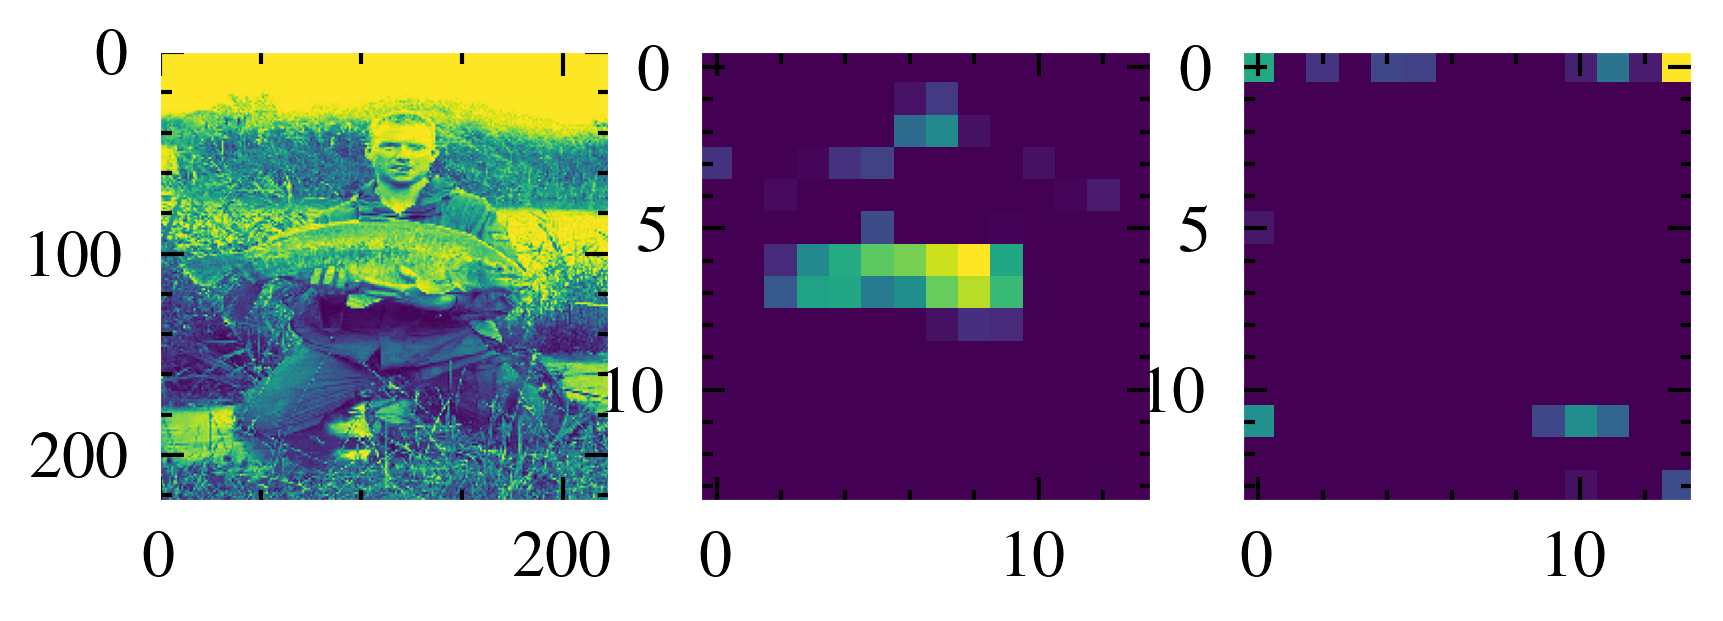

In [209]:
img = keras.applications.vgg16.preprocess_input(get_img_array(val_list[100], size=(224,224)))

secondLastGrads, lastGrads, secondLastOutput, lastOutput = kernel_grads(img, model, l_num)
#dy_dw_mag = tf.math.reduce_mean(dy_dw, axis=(0,1))
#feature.shape
topChannels = tf.math.top_k(secondLastGrads.numpy(), k=100).indices.numpy()
topFilters = tf.math.top_k(lastGrads.numpy(), k=100).indices.numpy()
print(topChannels)
fig , ax = plt.subplots(1,3)
ax[0].imshow(img[0,:,:,0])
ax[1].imshow(secondLastOutput[0,:,:,topChannels[1]])
ax[2].imshow(lastOutput[0,:,:,topFilters[2]])


 ============ LAYER -1 ==================
[137 330]
[155 329 441 193 113 320 472 101 165 153]
(3, 3, 512, 512)
(512, 512)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Rasterization of '<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x00000180CC305F88>' will be ignored
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Rasterization of '<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x00000180CBEA90C8>' will be ignored
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Rasterization of '<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x00000180CBECEA48>' will be ignored
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Rasterization of '<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x00000180CBEB11C8>' will be ignored
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Rasterization of '<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x

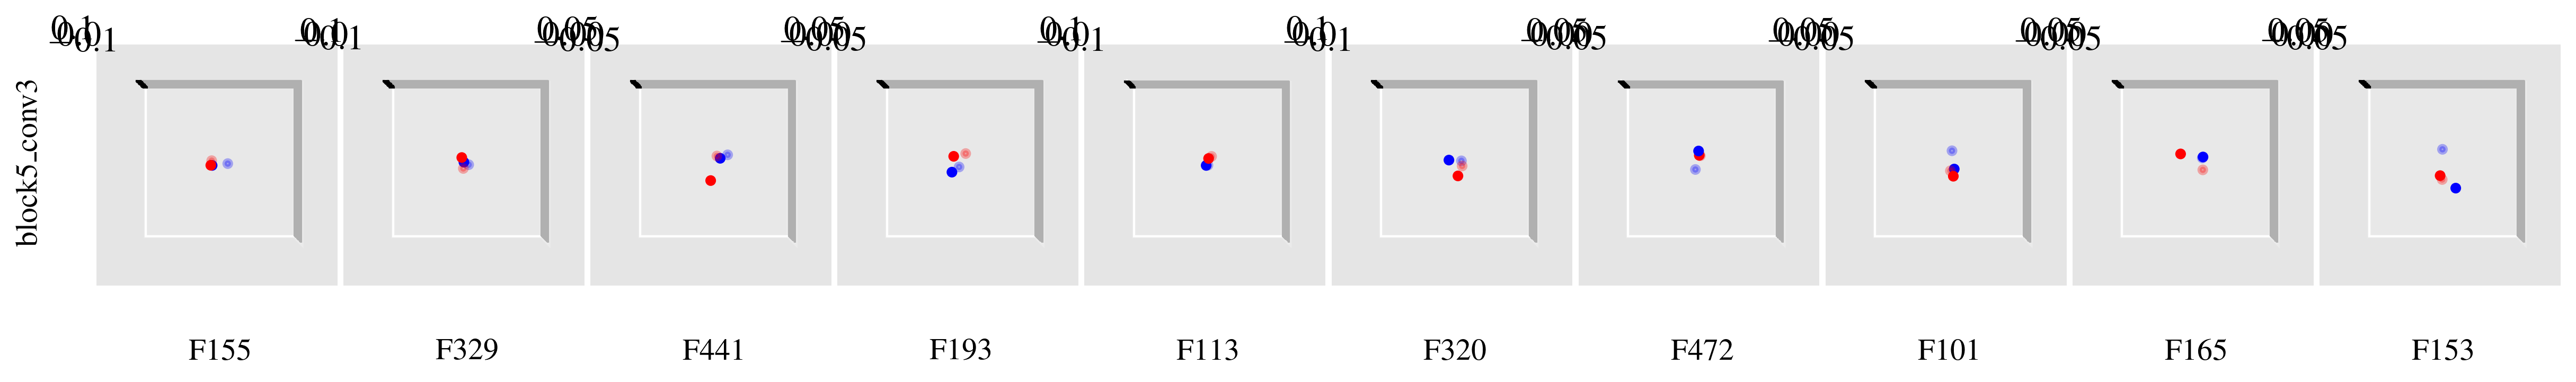

In [203]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '600'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []

fig= plt.figure(figsize = (10,13))
fig.clf()
#fig.tight_layout()
gs1 = gridspec.GridSpec(1, 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss, projection='3d') for ss in gs1]
ax = np.reshape(ax, (1, 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)



#fig.set_tight_layout(True)
print(f" ============ LAYER {l_num} ==================")
top10F= tf.math.top_k(lastGrads.numpy(), k=10).indices.numpy()  # topFilters.numpy()  #.indices#topKfilters(model, l_num, k=5)   #      #

topChannels = tf.math.top_k(secondLastGrads.numpy(), k=2).indices.numpy()
bottomChannels = tf.math.top_k(-secondLastGrads.numpy(), k=2).indices.numpy()

print(topChannels)

filters = get_filter(model, l_num)#[:,:,:, top10F]
print(top10F)
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

mag = reduce_euclidean_norm(filters, axis=[0,1])
dc = np.sign(np.mean(filters, axis=(0,1)))
print(dc.shape)
#find lims :

for i, F in enumerate(top10F):
	
	x =a_mag[:,F]*np.cos((theta[:,F]))
	y = a_mag[:,F]*np.sin((theta[:,F]))
	z = s_mag[:,F]*dc[:,F]
	lim_x = np.max(np.abs(x))
	lim_y = np.max(np.abs(y))
	lim_z = np.max(np.abs(z))
	lim = np.max([lim_x, lim_y, lim_z])
	#lim =np.max(np.abs(mag[:, i]))    
	lim*= 1.1

	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eig(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)
	if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1
	#print(e_val, e_vec)

	#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
	ax[0, i].set_xlim(-lim, lim)
	ax[0, i].set_ylim(-lim, lim)
	ax[0, i].set_zlim(-lim, lim)


	

	#color =  matplotlib.colors.Normalize()(np.abs(dy_dw_mag.numpy()[:, top10F[i]]))
	#alpha =  matplotlib.colors.Normalize()(dy_dw_mag.numpy()[:, top10F[i]])
	try:
		#ax[0, i].scatter(x[color>0.5],y[color>0.5],z[color>0.5], c=(dc[color>0.5, i]+1)/2, cmap="bwr",s=2)  
		ax[0, i].scatter(x.numpy()[topChannels],y.numpy()[topChannels],z.numpy()[topChannels], c='red',s=2)
		ax[0, i].scatter(x.numpy()[bottomChannels],y.numpy()[bottomChannels],z.numpy()[bottomChannels],  c='blue', cmap="Blues",s=2)

	except Exception as e:
		print(e)
		#ax[0, i].scatter()  

	ax[0, i].view_init(90,90)
	#ax[l_num, i].set_box_aspect((1,1,1))

	ax[0, i].set_xticks([])
	ax[0, i].set_yticks([])
	#ax[0, i].set_zticks([])

	#ax[l_num, i].set_aspect('equal')
	ax[0, i].collections[0].set_rasterized(True)

	#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
	#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
	'''ax[l_num, i].annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
				arrowprops=dict(arrowstyle="->",  color='black', lw=None))'''
	ax[0, i].set_xlabel(f"F{top10F[i]}", fontsize=7,) 
	ax[0, i].xaxis.set_label_position('top') 
	#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
for i in [-1]:
	
	ax[i, 0].set_ylabel(f"{conv_layers[i].name}", fontsize=7) 

#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)


In [100]:
mag.numpy().shape

(512, 512)

In [101]:
tf.math.top_k(dy_dw_mag.numpy()[:, top10F[1]], k=5)

NameError: name 'dy_dw_mag' is not defined

In [ ]:
bottomFilters

[4, 3, 2, 1, 0]

In [ ]:
(dc[color>0.90, i]+1)/2

array([1., 1., 0., 1.], dtype=float32)

In [ ]:
dc[dy_dw_mag[:, top10F[i]]>0.0]

array([[ 1., -1., -1., ..., -1., -1., -1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       [ 1., -1., -1., ..., -1.,  1.,  1.],
       ...,
       [-1.,  1., -1., ...,  1., -1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1., -1., -1.]], dtype=float32)